In [1]:
# Prediction with XGBOOST Direct Regression
#
# Direct Regression means one regression per future step


In [8]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from windrose import WindroseAxes
import xgboost as xgb

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, GaussianNoise, Input, BatchNormalization, ELU
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [9]:
#Import data
file = './YHZ_hourly/YHZ_hourly.csv'

df = pd.read_csv("./YHZ_Weather_1953_2022_High.csv")
df1 = pd.read_csv(file)
df99 = pd.read_csv("./climate-daily.csv")

/home/manero/DL/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,14,20,22,24,26,28,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df99.columns

Index(['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY',
       'MEAN_TEMPERATURE', 'MEAN_TEMPERATURE_FLAG', 'MIN_TEMPERATURE',
       'MIN_TEMPERATURE_FLAG', 'MAX_TEMPERATURE', 'MAX_TEMPERATURE_FLAG',
       'TOTAL_PRECIPITATION', 'TOTAL_PRECIPITATION_FLAG', 'TOTAL_RAIN',
       'TOTAL_RAIN_FLAG', 'TOTAL_SNOW', 'TOTAL_SNOW_FLAG', 'SNOW_ON_GROUND',
       'SNOW_ON_GROUND_FLAG', 'DIRECTION_MAX_GUST', 'DIRECTION_MAX_GUST_FLAG',
       'SPEED_MAX_GUST', 'SPEED_MAX_GUST_FLAG', 'COOLING_DEGREE_DAYS',
       'COOLING_DEGREE_DAYS_FLAG', 'HEATING_DEGREE_DAYS',
       'HEATING_DEGREE_DAYS_FLAG', 'MIN_REL_HUMIDITY', 'MIN_REL_HUMIDITY_FLAG',
       'MAX_REL_HUMIDITY', 'MAX_REL_HUMIDITY_FLAG'],
      dtype='object')

In [11]:
a = df1.columns

Index(['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY', 'LOCAL_HOUR',
       'TEMP', 'TEMP_FLAG', 'DEW_POINT_TEMP', 'DEW_POINT_TEMP_FLAG', 'HUMIDEX',
       'HUMIDEX_FLAG', 'PRECIP_AMOUNT', 'PRECIP_AMOUNT_FLAG',
       'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_FLAG', 'STATION_PRESSURE',
       'STATION_PRESSURE_FLAG', 'VISIBILITY', 'VISIBILITY_FLAG', 'WINDCHILL',
       'WINDCHILL_FLAG', 'WIND_DIRECTION', 'WIND_DIRECTION_FLAG', 'WIND_SPEED',
       'WIND_SPEED_FLAG'],
      dtype='object')

In [1]:
# Downsample series to average temp per day
df_day_grouped = df2.set_index('date').groupby(pd.Grouper(freq='d')).agg({'TEMP': ['mean', 'min', 'max']})
df_day_grouped = df_day_grouped.reset_index()
df_day_grouped.columns = df_day_grouped.columns.map(''.join)

NameError: name 'df2' is not defined

In [12]:
# we create a datetime index
df1['date'] = pd.to_datetime(df1['LOCAL_DATE'])
df1 = df1.sort_values('date')
df1 = df1.reset_index(drop=True)

=======================================================
##### Data Matrix Preparation 
We transform the file in as sequence of examples \
(1) 1 2 3 4 5 6 7 8 9 10 -> lag 2 \
(1) 12, 23, 34, 45, 56, 67, 78, 89, 910 \
(2) 1 2 3 4 5 6 7 8 9 10 -> lag 3  \
(2) 123, 234, 345, 456, 567, 678, 789, 8910,  \ 

In [20]:
df1

,x,y,STATION_NAME,CLIMATE_IDENTIFIER,ID,LOCAL_DATE,PROVINCE_CODE,LOCAL_YEAR,LOCAL_MONTH,LOCAL_DAY,...,STATION_PRESSURE_FLAG,VISIBILITY,VISIBILITY_FLAG,WINDCHILL,WINDCHILL_FLAG,WIND_DIRECTION,WIND_DIRECTION_FLAG,WIND_SPEED,WIND_SPEED_FLAG,date
0,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.6,1961-01-03 06:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-9.0,NaN,25.0,NaN,8.0,NaN,1961-01-03 06:00:00
1,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.7,1961-01-03 07:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-11.0,NaN,29.0,NaN,10.0,NaN,1961-01-03 07:00:00
2,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.8,1961-01-03 08:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-11.0,NaN,25.0,NaN,10.0,NaN,1961-01-03 08:00:00
3,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.9,1961-01-03 09:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-11.0,NaN,29.0,NaN,10.0,NaN,1961-01-03 09:00:00
4,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.10,1961-01-03 10:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-10.0,NaN,29.0,NaN,8.0,NaN,1961-01-03 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379361,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.19,2022-07-09 19:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,32.0,NaN,19.0,NaN,2022-07-09 19:00:00
379362,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.20,2022-07-09 20:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,32.0,NaN,14.0,NaN,2022-07-09 20:00:00
379363,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.21,2022-07-09 21:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,27.0,NaN,10.0,NaN,2022-07-09 21:00:00
379364,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.22,2022-07-09 22:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,27.0,NaN,14.0,NaN,2022-07-09 22:00:00


In [21]:
# Data Matrix Preparation


df1.columns
cols = ['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY', 'LOCAL_HOUR',
       'TEMP', 'TEMP_FLAG', 'DEW_POINT_TEMP', 'DEW_POINT_TEMP_FLAG', 'HUMIDEX',
       'HUMIDEX_FLAG', 'PRECIP_AMOUNT', 'PRECIP_AMOUNT_FLAG',
       'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_FLAG', 'STATION_PRESSURE',
       'STATION_PRESSURE_FLAG', 'VISIBILITY', 'VISIBILITY_FLAG', 'WINDCHILL',
       'WINDCHILL_FLAG', 'WIND_DIRECTION', 'WIND_DIRECTION_FLAG', 'WIND_SPEED',
       'WIND_SPEED_FLAG', 'date']

drop_cols = ['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY', 'LOCAL_HOUR']

ts_multivar = df1.drop(drop_cols, axis=1)

Nan_cols = ['DEW_POINT_TEMP_FLAG', 'HUMIDEX', 'HUMIDEX_FLAG', 'PRECIP_AMOUNT', 'STATION_PRESSURE_FLAG',
           'PRECIP_AMOUNT_FLAG', 'RELATIVE_HUMIDITY_FLAG', 'VISIBILITY_FLAG', 'WINDCHILL_FLAG',
           'WIND_DIRECTION_FLAG', 'WIND_SPEED_FLAG', 'WINDCHILL', 'TEMP_FLAG']
ts_multivar = ts_multivar.drop(Nan_cols, axis=1)


In [23]:
ts_multivar.isna().sum().sum()
ts_multivar = ts_multivar.dropna()
ts_multivar_original = ts_multivar

In [24]:
ts_multivar = ts_multivar.drop('date', axis=1)
weather_data = ts_multivar.to_numpy()
weather_data.shape

(378830, 7)

In [25]:
#===================
lag = 48
ahead = 24
#====================

# Examples dataframe creation
#print('Input dataframe structure', ts_multivar.shape)

# create train, test, val (60%, 20%, 20%)
train_split = 0.6
test_split = 0.2

datasize =  weather_data.shape[0]
trainsize = int(datasize * train_split)
half_test = int(datasize * test_split)
testsize = int(half_test*2)

sc=StandardScaler()
tmpdata = sc.fit_transform(weather_data)
Scaler = sc.fit(weather_data[:, 0].reshape(-1, 1))  # saves the scaler for the first variable for descaling
#Scaler = sc.fit(weather_data[:, 0])  # saves the scaler for the first variable for descaling
weather_data = tmpdata


In [26]:
t_s_multivariate = weather_data

def lag_matrix(wind_train, lag=lag, ahead=ahead):
    wind_train = data[:trainsize, :]
    lvect = []
    for i in range(lag + ahead):
       lvect.append(data[i: -lag - ahead + i, :])
    return(np.stack(lvect, axis=1))

# data = train -> test -> val

data = t_s_multivariate[:trainsize, :]

train = lag_matrix(data, lag, ahead)

train_x = train[:, :lag]
train_x = np.swapaxes(train_x, 1, 2)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1] * train_x.shape[2]))

data  = t_s_multivariate[trainsize:trainsize + testsize, :]

test  = lag_matrix(data, lag, ahead)
half_test = int(test.shape[0] / 2)

test_x = test[:half_test, :lag]
val_x = test[half_test:, :lag]

train_y = train[:, -ahead:, 0]
test_y   = test[:half_test, -ahead:, 0]
val_y  = test[half_test:, -ahead:, 0]


test_x = np.swapaxes(test_x, 1, 2)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1] * test_x.shape[2]))
val_x = np.swapaxes(val_x, 1, 2)
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1] * val_x.shape[2]))


print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("shape x_val      : ", val_x.shape,  " y_val       : ", val_y.shape)
print("=============================================================")

input_dimensions = train_x.shape[1:]
print(input_dimensions)

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (227226, 336)  y_training: :  (227226, 24)
shape x_test     :  (75730, 336)  y_test      :  (75730, 24)
shape x_val      :  (75730, 336)  y_val       :  (75730, 24)
(336,)


In [73]:
# xgboost regression
XGB = xgb.XGBRegressor()

# xgboost prediction

XGB.fit(train_x, train_y[:,0])

val_yp = XGB.predict(val_x) 
test_yp = XGB.predict(test_x) 

for i in range (1, ahead):
   XGB.fit(train_x, train_y[:,i])
   z1 = XGB.predict(val_x) 
   z2 = XGB.predict(test_x) 
   val_yp = np.column_stack((val_yp,z1))
   test_yp = np.column_stack((test_yp,z2))

print(val_yp.shape, test_yp.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
(75730, 24) (75730, 24)


In [74]:
print('val_yp.shape', val_yp.shape, 'test_yp.shape', test_yp.shape)


val_yp.shape (75730, 24) test_yp.shape (75730, 24)


In [75]:
# Evaluating results

lresults = []
val_y_R2 = []
test_y_R2 = []
acum_val, acum_test = 0,0
for i in range (1,ahead+1):
   v_yp = Scaler.inverse_transform(val_yp[:, i - 1].reshape(-1,1))
   v_y = Scaler.inverse_transform(val_y[:, i - 1].reshape(-1,1))
   t_yp = Scaler.inverse_transform(test_yp[:, i - 1].reshape(-1,1))
   t_y = Scaler.inverse_transform(test_y[:, i - 1].reshape(-1,1))
   val_y_R2.append(r2_score(v_yp,v_y))
   test_y_R2.append(r2_score(t_yp, t_y))
   
print ("Results === Test == Validation ")
print('=============================')
for i in range (0,ahead):
   print('step', "{:<4d}".format(i+1), '- ', "{:.3f}".format(val_y_R2[i]), "   {:.3f}".format(test_y_R2[i]))          
   acum_val = acum_val + val_y_R2[i]
   acum_test = acum_test + test_y_R2[i]
print('=============================')
print('Summary', '  - ', "{:.3f}".format(acum_val), "   {:.3f}".format(acum_test))

Results === Test == Validation 
step 1    -  0.995    0.994
step 2    -  0.986    0.984
step 3    -  0.975    0.973
step 4    -  0.962    0.960
step 5    -  0.950    0.949
step 6    -  0.937    0.937
step 7    -  0.926    0.927
step 8    -  0.915    0.918
step 9    -  0.906    0.908
step 10   -  0.896    0.900
step 11   -  0.890    0.893
step 12   -  0.882    0.885
step 13   -  0.877    0.880
step 14   -  0.869    0.874
step 15   -  0.865    0.869
step 16   -  0.859    0.864
step 17   -  0.856    0.859
step 18   -  0.849    0.854
step 19   -  0.843    0.850
step 20   -  0.841    0.847
step 21   -  0.836    0.843
step 22   -  0.832    0.838
step 23   -  0.825    0.834
step 24   -  0.821    0.829
Summary   -  21.393    21.471


In [76]:
v_yp.shape

(75730, 1)

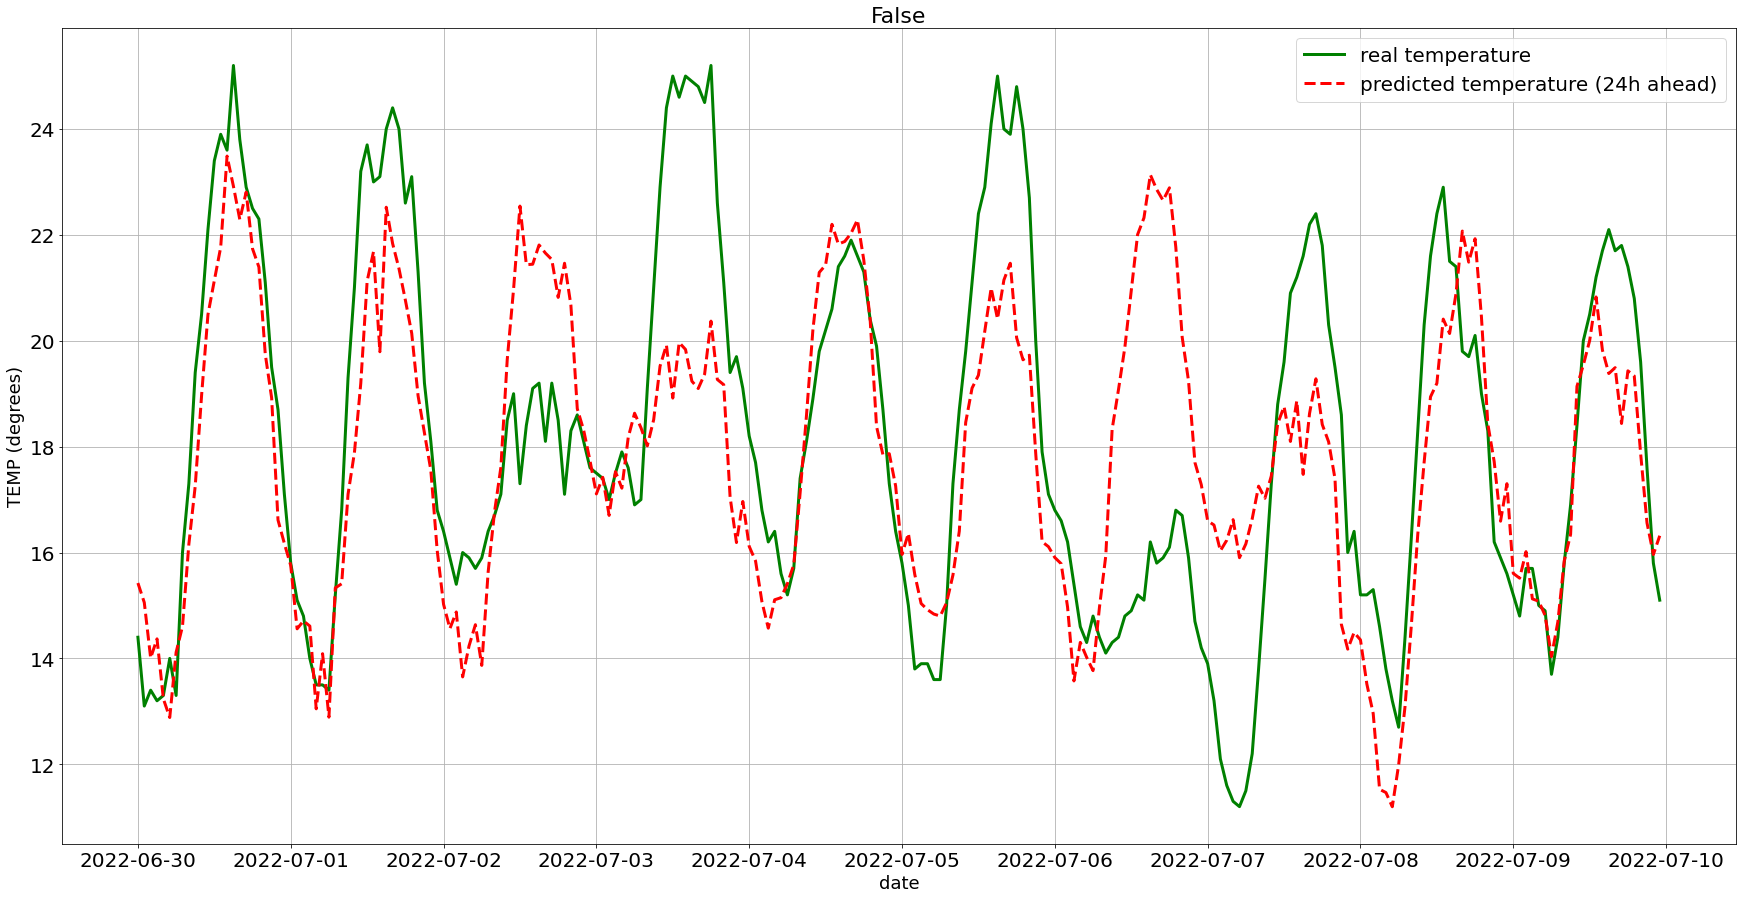

In [77]:
#plot prediction and ground truth
# Let's do it for the last 100 days
N = 240
d = [x for x in range(N)]
d1 = ts_multivar_original.iloc[-N:]

df_temps = df_day_grouped[df_day_grouped['date'].dt.year == 2021 ]
fig, ax = plt.subplots(figsize=(30,15))

ax.plot(d1['date'],v_y[-N:,],color='green',linewidth=3.0, )
ax.plot(d1['date'],v_yp[-N:,],color='red',linewidth=3.0, linestyle='--')
ax.legend(["real temperature", "predicted temperature (24h ahead)"])
plt.title("10 days Temp Prediction in Standsed Airport HALIFAX" in "+str(y)", size=22)
plt.ylabel("TEMP (degrees)", size=18)
plt.xlabel("date", size=18)
plt.grid(axis='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

<Figure size 1440x720 with 0 Axes>

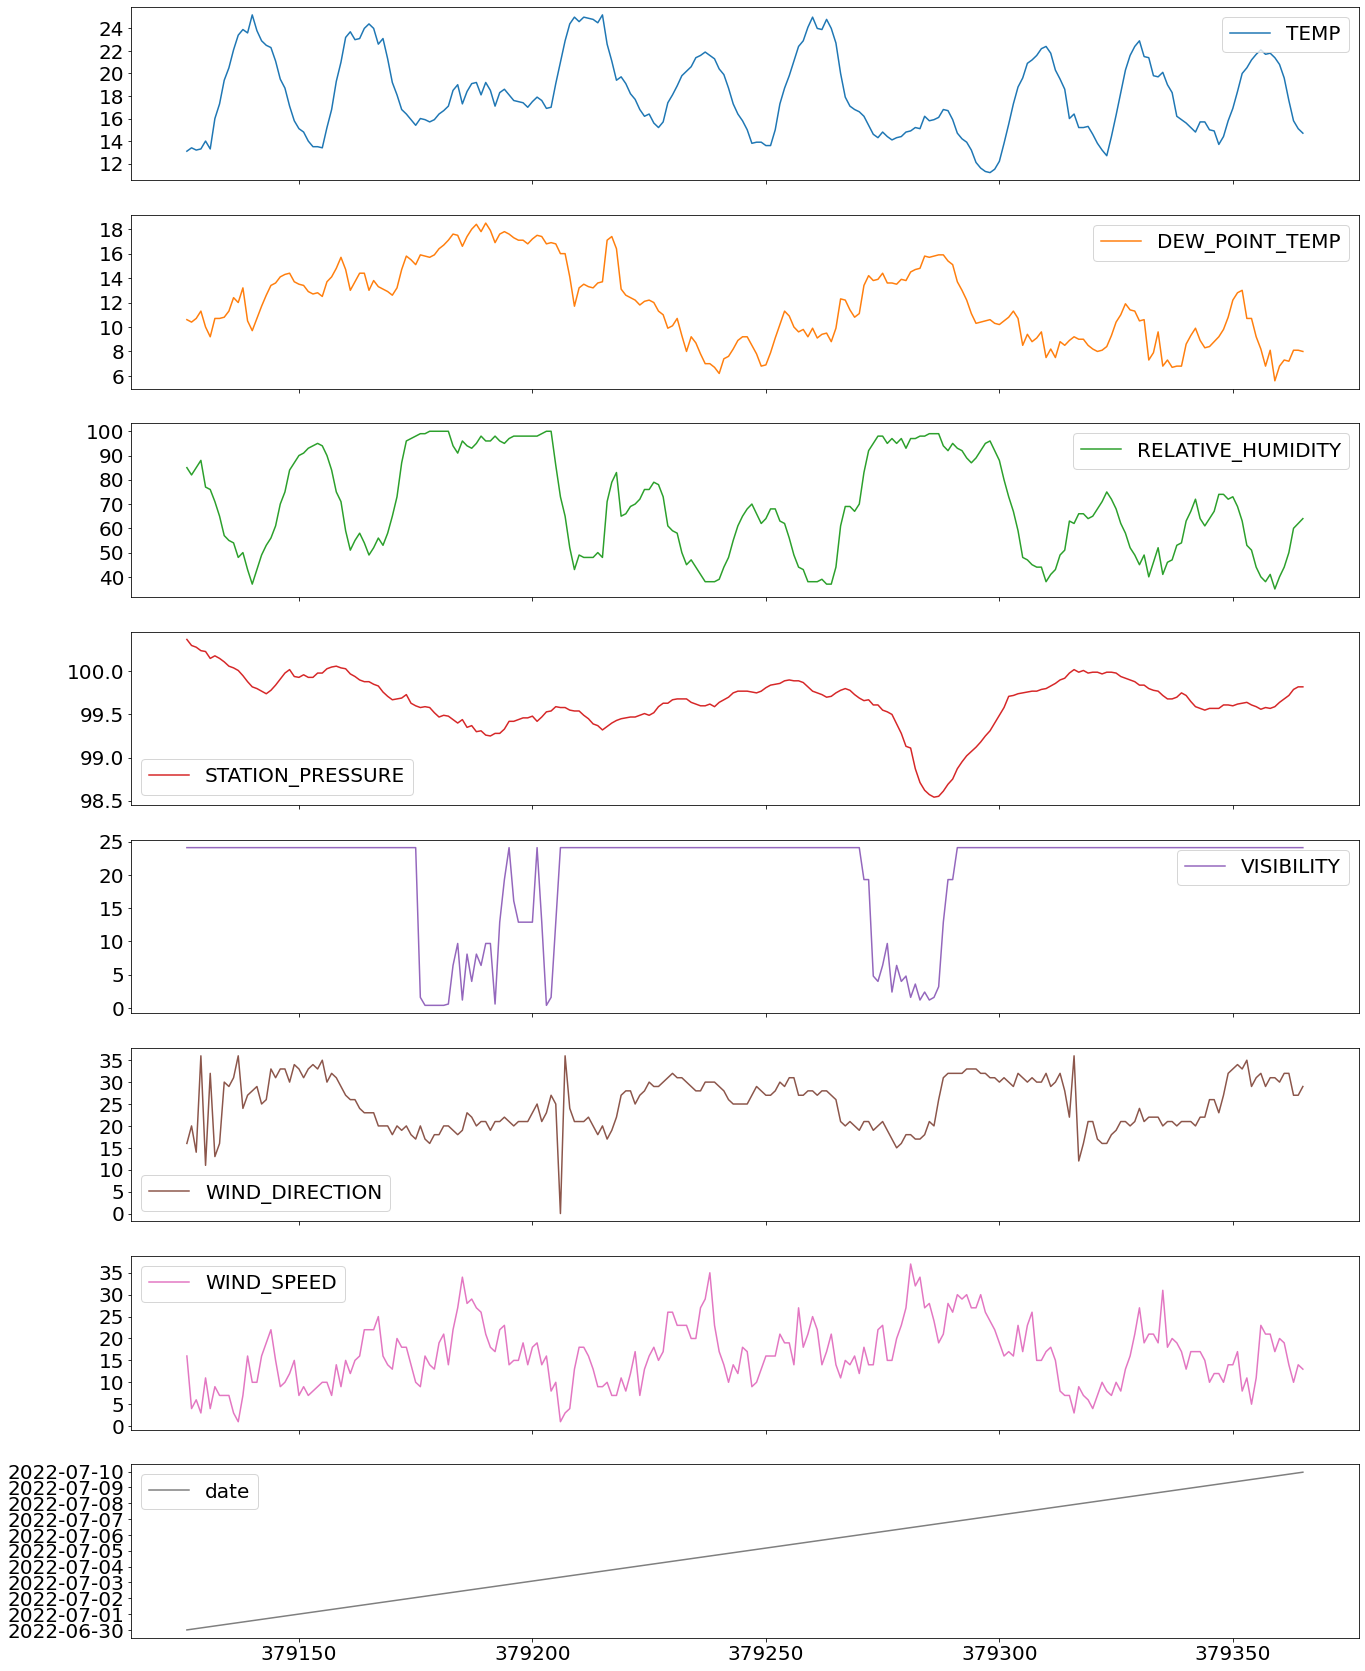

In [78]:
df = d1

plt.figure(figsize=(20,10))
plt.rc('legend', fontsize=20)
df.plot(subplots=True, legend=True, figsize=(22,30), use_index=True, fontsize=20)
plt.show()